In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy as sc
import logging
import glob
from functools import lru_cache
import time


In [2]:

# Global cache for device combinations by width to avoid rebuilding
DEVICE_COMBS = {}

@lru_cache(maxsize=128)
def unitcell_leads(w,d,t,e,l):
    # convert to native python types to ensure stable hashing for caching
    w = float(w); d = float(d); t = float(t); e = float(e); l = int(l)
    # logger.debug("unitcell_leads called with w=%s, d=%s, t=%s, e=%s, l=%s", w, d, t, e, l)
    n = l
    H = (w + 1J * d - e) * np.eye(n,dtype=complex)
    # set nearest-neighbour (adjacent) hopping terms
    if n > 1:
        ind = np.arange(0, n-1, 1)
        H[ind, ind+1] = t
        H[ind+1, ind] = t
    # logger.debug("unitcell_leads returning matrix of shape %s", H.shape)
    return H

@lru_cache(maxsize=128)
def unitcell_leads_inv(w,d,t,e,l):
    # cached inverse of unitcell_leads
    w = float(w); d = float(d); t = float(t); e = float(e); l = int(l)
    mat = unitcell_leads(w,d,t,e,l)
    try:
        inv = np.linalg.inv(mat)
    except np.linalg.LinAlgError:
        logger.exception("Failed to invert unitcell_leads for parameters %s", (w,d,t,e,l))
        raise
    return inv


def computed_leads(l):
    """Find existing lead files using glob instead of checking every w step.
    This avoids looping over all possible w values and calling os.path.exists repeatedly.
    """
    leads = {}
    # logger.debug("computed_leads scanning for lead files for l=%s using glob", l)
    pattern = os.path.expanduser(f'~/Downloads/transmissions/leads/leads_{l}_w_*.csv')
    for fn in glob.glob(pattern):
        try:
            base = os.path.basename(fn)
            # expect format leads_{l}_w_{w:.2f}.csv
            parts = base.rsplit('_w_', 1)
            if len(parts) != 2:
                # logger.debug("Skipping file with unexpected name format: %s", base)
                continue
            w_str = parts[1].rsplit('.csv', 1)[0]
            w = float(w_str)
            leads[w] = np.loadtxt(fn, delimiter=',', dtype=complex)
            # logger.debug("Loaded lead file %s for w=%s", fn, w)
        except Exception:
            logger.exception("Failed to load lead file %s", fn)
    # logger.debug("computed_leads found %s lead entries", len(leads))
    return leads


In [3]:
np.degrees(np.arctan(12.5 / 7.25))

59.88626684901757

In [4]:


@lru_cache(maxsize=1024)
def chosen_for_config(n, width, config):
    """Return the chosen (n) device_combs rows for a given config (seed).
    This is cached so the RNG and selection run once per (n,width,config).
    """
    width = int(width); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    """Backward-compatible factory that returns a function drawing from cached chosen rows.
    But we no longer rebuild device_combs every call.
    """
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed



In [5]:
chosen_for_config(10, 25,1)

array([[56,  6],
       [11, 22],
       [51,  1],
       [94, 18],
       [17, 13],
       [80,  9],
       [25, 17],
       [26,  5],
       [47, 18],
       [96, 10]])

In [6]:

def unidevice(w,d,t,e,l,config,n,numberofunitcell, combs_fn=None):
    """Build the unit device matrix for a single seed (config).
    Accept an optional combs_fn to avoid recreating selection logic repeatedly.
    """
    # logger.debug("unidevice called with w=%s, d=%s, t=%s, e=%s, l=%s, config=%s, n=%s, numberofunitcell=%s", w,d,t,e,l,config,n,numberofunitcell)
    if combs_fn is None:
        combs_fn = possible_combs(n, l)
    imps = combs_fn(config)
    x = imps[:, 0]
    y = imps[:, 1]
    z = int(numberofunitcell)
    mat = unitcell_leads(w, d, t, e, l)
    # logger.debug("unidevice initial mat shape %s", mat.shape)
    if np.any(z == x):
        indices = np.where(x == z)[0]
        y1 = y[indices]
        # logger.debug("unidevice matched indices %s with y values %s", indices, y1)
        # apply modifications per index (correct per-index assignment)
        for i in y1:
            mat[int(i), int(i)] = (w + 1j * d - 0.5)
        # logger.debug("unidevice modified mat at indices %s", y1)
        return mat

    # logger.debug("unidevice no modification needed")
    return mat


In [11]:
size = 10
leads_size = computed_leads(size)

In [12]:

def device(w,d,t,e,l,config,n):
    # logger.debug("device called with w=%s, d=%s, t=%s, e=%s, l=%s, config=%s, n=%s", w,d,t,e,l,config,n)
    hopp = np.eye(l, dtype=complex)
    w = round(w,2)
    # use cached inverse of unitcell_leads
    try:
        unit = unitcell_leads_inv(w, d, t, e, l)
    except Exception:
        logger.exception("Failed to get cached inverse for unitcell_leads; falling back to direct inv")
        unit = np.linalg.inv(unitcell_leads(w, d, t, e, l))

    g = unit.copy()
    iden = np.eye(l, dtype=complex)

    G = leads_size.get(w)
    if G is None:
        logger.error("No lead data for w=%s; aborting device calculation and returning np.nan", w)
        return np.nan

    # logger.info("G shape: %s", np.shape(G))
    g_hopp = g @ hopp

    tol = 1e-8
    max_iter = 100
    converged = False

    # prepare cached combs function once to avoid rebuilding inside loop
    combs_fn = possible_combs(n, l)

    # Iterative solver with convergence check and tqdm progress bar
    for x in range(max_iter):
        iter_start = time.perf_counter()
        try:
            t1 = time.perf_counter()
            mat = unidevice(w, d, t, e, l, config, n, x, combs_fn=combs_fn)
            t_mat = time.perf_counter() - t1
            t2 = time.perf_counter()
            g_d = np.linalg.inv(mat)
            t_inv = time.perf_counter() - t2
        except np.linalg.LinAlgError:
            logger.exception("Singular matrix encountered at iteration %s while inverting unidevice matrix", x)
            return np.nan
        except Exception:
            logger.exception("Unexpected error in unidevice/inversion at iteration %s", x)
            return np.nan

        A = iden - g_d @ hopp @ G @ hopp
        try:
            t3 = time.perf_counter()
            G_new = np.linalg.solve(A, g_d)
            t_solve = time.perf_counter() - t3
        except np.linalg.LinAlgError:
            logger.exception("Linear solve failed at iteration %s", x)
            return np.nan

        diff_norm = np.linalg.norm(G_new - G)
        iter_time = time.perf_counter() - iter_start

        # log timing and shapes on the first iteration to identify bottleneck
        if x == 0:
            # logger.info("First-iteration timings (s): mat_build=%0.6f, mat_inv=%0.6f, solve=%0.6f, iter_total=%0.6f", t_mat, t_inv, t_solve, iter_time)
            # logger.info("Shapes: mat=%s, G=%s", np.shape(mat), np.shape(G))
            pass

        if x % 10 == 0:
            # logger.debug("Iteration %s: norm(G_new)=%s, diff_norm=%s, iter_time=%s", x, np.linalg.norm(G_new), diff_norm, iter_time)
            pass

        G = G_new
        if diff_norm < tol:
            # logger.debug("Converged after %s iterations with diff %s", x + 1, diff_norm)
            converged = True
            break

    if not converged:
        # logger.debug("Did not converge after %s iterations; continuing with last G", max_iter)
        pass

    left_device = G
    right = leads_size.get(w)
    if right is None:
        logger.error("Right lead unexpectedly missing for w=%s", w)
        return np.nan

    # connect left to right lead
    try:
        c_l_1 = iden - right @ hopp @ left_device @ hopp
        c_l = np.linalg.solve(c_l_1, left_device)
        c_l_2 = iden - left_device @ hopp @ right @ hopp
        c_r = np.linalg.solve(c_l_2, right)
    except np.linalg.LinAlgError:
        logger.exception("Failed to connect left and right leads via linear solve")
        return np.nan

    # transmission and greens functions
    G_ll = c_l - np.transpose(np.conjugate(c_l))
    G_rr = c_r - np.transpose(np.conjugate(c_r))
    G_lr = left_device @ hopp @ c_r
    Gnon = G_lr - np.transpose(np.conjugate(G_lr))

    tr1 = G_ll @ hopp @ G_rr @ hopp - hopp @ Gnon @ hopp @ Gnon
    tr2 = np.trace(tr1).sum()
    # logger.debug("device computed tr2 (raw)=%s", tr2)

    return np.abs(tr2)

In [25]:
###device(w,d,t,e,l,config,n)###
pris = [device(w,0.0001,1,0,10,1,0) for w in np.arange(0, 4, 0.01)]
out_dir = os.path.expanduser('~/Downloads/transmissions/size_10')
np.savetxt(os.path.join(out_dir, 'size_10_pris.csv'), pris, delimiter=',')

In [21]:
transmission = [device(w,0.0001,1,0,10,1,10) for w in np.arange(0, 4, 0.01)]

transmission = np.clip(transmission,0,pris)

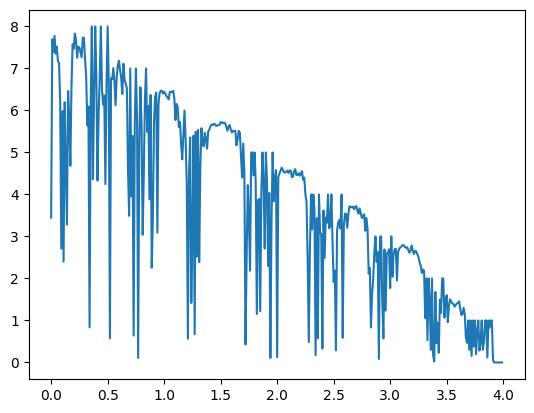

In [22]:
plt.plot(np.arange(0, 4, 0.01), np.clip(transmission,0,10))

In [9]:
out_dir = os.path.expanduser('~/Downloads/transmissions/size_10')
os.makedirs(out_dir, exist_ok=True)
ws = np.arange(0, 4, 0.01)
for conc in np.arange(7,50,2):
    print(conc)
    for config in range(5000):
        transmission = [device(w, 0.0001, 1, 0, size, config, int(conc)) for w in ws]
        fn = os.path.join(out_dir, f'lead_size_{size}_conc_{int(conc)}_config_{config}.csv')
        np.savetxt(fn, np.column_stack((ws, transmission)), delimiter=',', header='w,G', comments='')

7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
